In [1]:
import numpy as np
from skimage import io, color, feature
import skimage
import glob
import random
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
faces = []
for img_name in glob.glob("train/faces/*.png"):
    img = io.imread(img_name)
    if len(img.shape) != 3:
        img = color.gray2rgb(img)
    faces.append(io.imread(img_name))

In [3]:
non_faces = []
for img_name in glob.glob("train/non-faces/*.png"):
    img = io.imread(img_name)
    if len(img.shape) != 3:
        img = color.gray2rgb(img)
    non_faces.append(io.imread(img_name))

In [4]:
train_images = faces + non_faces

In [7]:
hog_train_images = []
for img in train_images:
    hog_train_images.append(feature.hog(color.rgb2gray(img), orientations=9, 
                                        cells_per_block=(1, 1), pixels_per_cell=(3, 4)))
hog_train_images = np.array(hog_train_images)

In [5]:
lables = np.array([1] * len(faces) + [0] * len(non_faces))

In [8]:
p = np.random.permutation(len(hog_train_images))
X, y =  hog_train_images[p], lables[p]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1)

In [12]:
from sklearn.svm import SVC
clf = SVC(probability=True)
clf.fit(X_train, y_train)
y_pred = clf.predict_proba(X_val)
print roc_auc_score(y_val, y_pred[:, 1])

0.99676375404530748

In [14]:
test_images = []
for img_name in glob.glob("test/*.jpg"):
    img = io.imread(img_name)
    if len(img.shape) != 3:
        img = color.gray2rgb(img)
    test_images.append(io.imread(img_name))

In [15]:
window_size = (32, 24, 3)

def find_face(img):    
    pred_matrix = np.zeros((img.shape[0] - window_size[0], img.shape[1] - window_size[1]))
    for i in range(pred_matrix.shape[0]):
        for j in range(pred_matrix.shape[1]):
            window = img[i: i + window_size[0], j: j + window_size[1]]
            window_hog = feature.hog(color.rgb2gray(window), orientations=9, cells_per_block=(1, 1), pixels_per_cell=(3, 4))
            pred_matrix[i][j] = clf.predict_proba(window_hog.reshape(1, -1))[0][1] 
            
    best_proba, best_i, best_j = 0, 0, 0
    for i in range(1, pred_matrix.shape[0] - 1):
        for j in range(1, pred_matrix.shape[1] - 1):
            curr_proba = np.mean([pred_matrix[i-1][j-1], pred_matrix[i-1][j], pred_matrix[i][j-1], 
                                 pred_matrix[i][j], pred_matrix[i+1][j+1], pred_matrix[i][j+1], 
                                 pred_matrix[i+1][j], pred_matrix[i-1][j+1], pred_matrix[i+1][j-1]])
            if curr_proba >= best_proba:
                best_proba = curr_proba
                best_i = i
                best_j = j
    return best_i, best_j

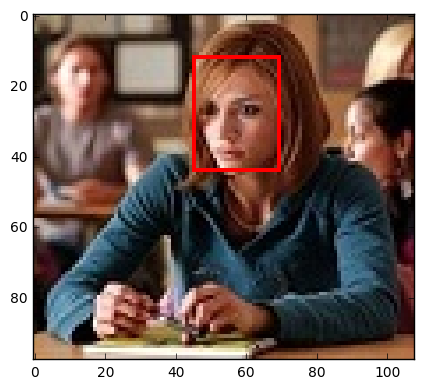

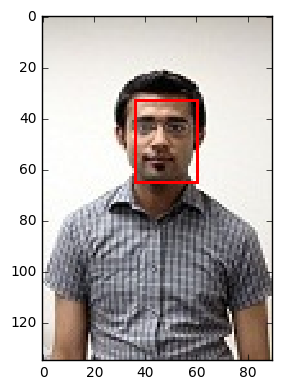

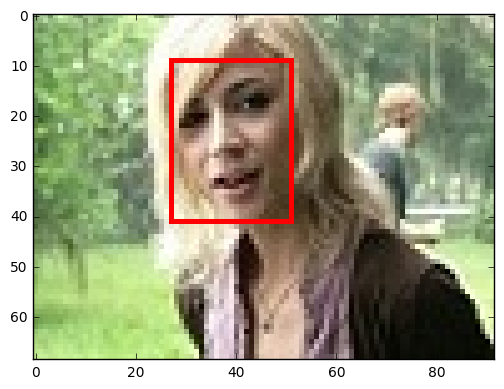

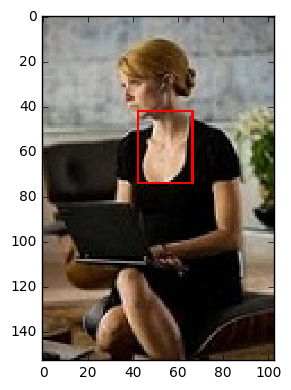

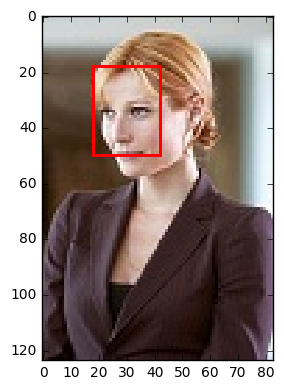

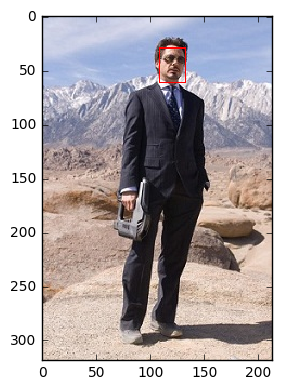

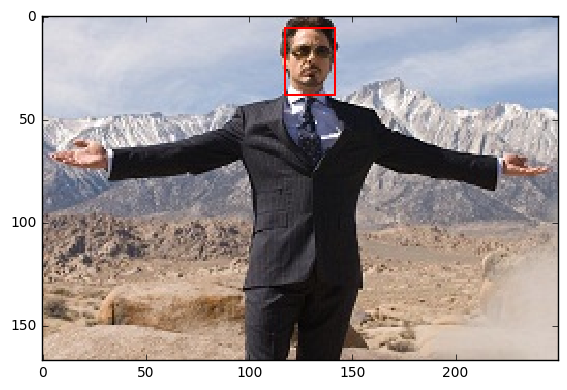

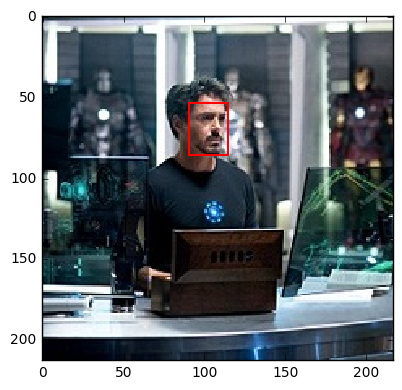

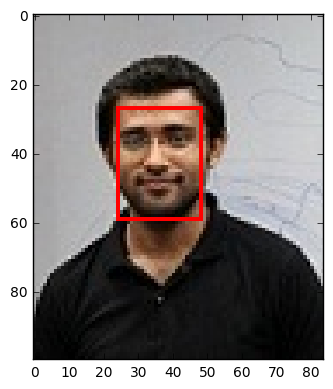

In [26]:
plt.figure(figsize=(10, 10))
for i in range(len(test_images)):
    img = test_images[i].copy()
    best_i, best_j = find_face(img)
    img[skimage.draw.polygon_perimeter([best_i, best_i, best_i + window_size[0], best_i + window_size[0]],
                                       [best_j + window_size[1], best_j, best_j, best_j + window_size[1]])] = [255,0,0]
    io.imshow(img)
    plt.show()